In [1]:
import pandas as pd
import nltk
from nltk import FreqDist
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
like = pd.read_excel('/Users/reggieyang/Desktop/Python/Summer Projects/NLP/like.xlsx')

In [3]:
column_name = like.columns[0]
like.rename({column_name:'like_review'},axis=1,inplace=True)


In [4]:
# Apply text cleaning using regular expression
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

tc = lambda x: clean_text(x)

# Let's take a look at the updated text
data_clean = pd.DataFrame(like.like_review.apply(tc))
data_clean.head()

<>:8: DeprecationWarning: invalid escape sequence \[
<>:10: DeprecationWarning: invalid escape sequence \w
<>:8: DeprecationWarning: invalid escape sequence \[
<>:10: DeprecationWarning: invalid escape sequence \w
<>:8: DeprecationWarning: invalid escape sequence \[
<>:10: DeprecationWarning: invalid escape sequence \w
<ipython-input-4-f073003bdb1b>:8: DeprecationWarning: invalid escape sequence \[
  text = re.sub('\[.*?\]', '', text)
<ipython-input-4-f073003bdb1b>:10: DeprecationWarning: invalid escape sequence \w
  text = re.sub('\w*\d\w*', '', text)


,like_review
0,learning new things outside my field and being inspired by cutting edge advances in theory or experiment love to read it cover to cover but had not caught up to the nov issue yet subject of this...
1,science articles product reviews science news and historical articles
2,the variety of hot topics and the historical tidbits
3,keeps me up to date and exposes me to new research
4,i like the discovery news and the articles on environmental issues


In [5]:
#Lemmatize data
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
def to_string(df):
    return ' '.join(df)

data_clean['text_lemmatized'] = data_clean.like_review.apply(lemmatize_text)
data_clean['text_lemmatized'] = data_clean['text_lemmatized'].map(to_string)

data_clean.head()
#data_clean.to_csv('/Users/reggieyang/Desktop/Python/Summer Projects/NLP/dataset/like_data_clean.csv',index=False)

,like_review,text_lemmatized
0,learning new things outside my field and being inspired by cutting edge advances in theory or experiment love to read it cover to cover but had not caught up to the nov issue yet subject of this...,learning new thing outside my field and being inspired by cutting edge advance in theory or experiment love to read it cover to cover but had not caught up to the nov issue yet subject of this survey
1,science articles product reviews science news and historical articles,science article product review science news and historical article
2,the variety of hot topics and the historical tidbits,the variety of hot topic and the historical tidbit
3,keeps me up to date and exposes me to new research,keep me up to date and expose me to new research
4,i like the discovery news and the articles on environmental issues,i like the discovery news and the article on environmental issue


In [6]:
#Remove stop words
from nltk.corpus import stopwords
#nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_add = 'much,enjoy,physics,article,articles,well,interesting,area,topic'.split(',')
for i in range(len(stop_add)):
    stop_words.append(stop_add[i])

data_clean['reviews_without_stopwords'] = data_clean['text_lemmatized'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
data_clean.head()

,like_review,text_lemmatized,reviews_without_stopwords
0,learning new things outside my field and being inspired by cutting edge advances in theory or experiment love to read it cover to cover but had not caught up to the nov issue yet subject of this...,learning new thing outside my field and being inspired by cutting edge advance in theory or experiment love to read it cover to cover but had not caught up to the nov issue yet subject of this survey,learning new thing outside field inspired cutting edge advance theory experiment love read cover cover caught nov issue yet subject survey
1,science articles product reviews science news and historical articles,science article product review science news and historical article,science product review science news historical
2,the variety of hot topics and the historical tidbits,the variety of hot topic and the historical tidbit,variety hot historical tidbit
3,keeps me up to date and exposes me to new research,keep me up to date and expose me to new research,keep date expose new research
4,i like the discovery news and the articles on environmental issues,i like the discovery news and the article on environmental issue,like discovery news environmental issue


# Data Modeling & Data Visulization 

In [7]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,10))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.tight_layout()
    plt.show()
    
 

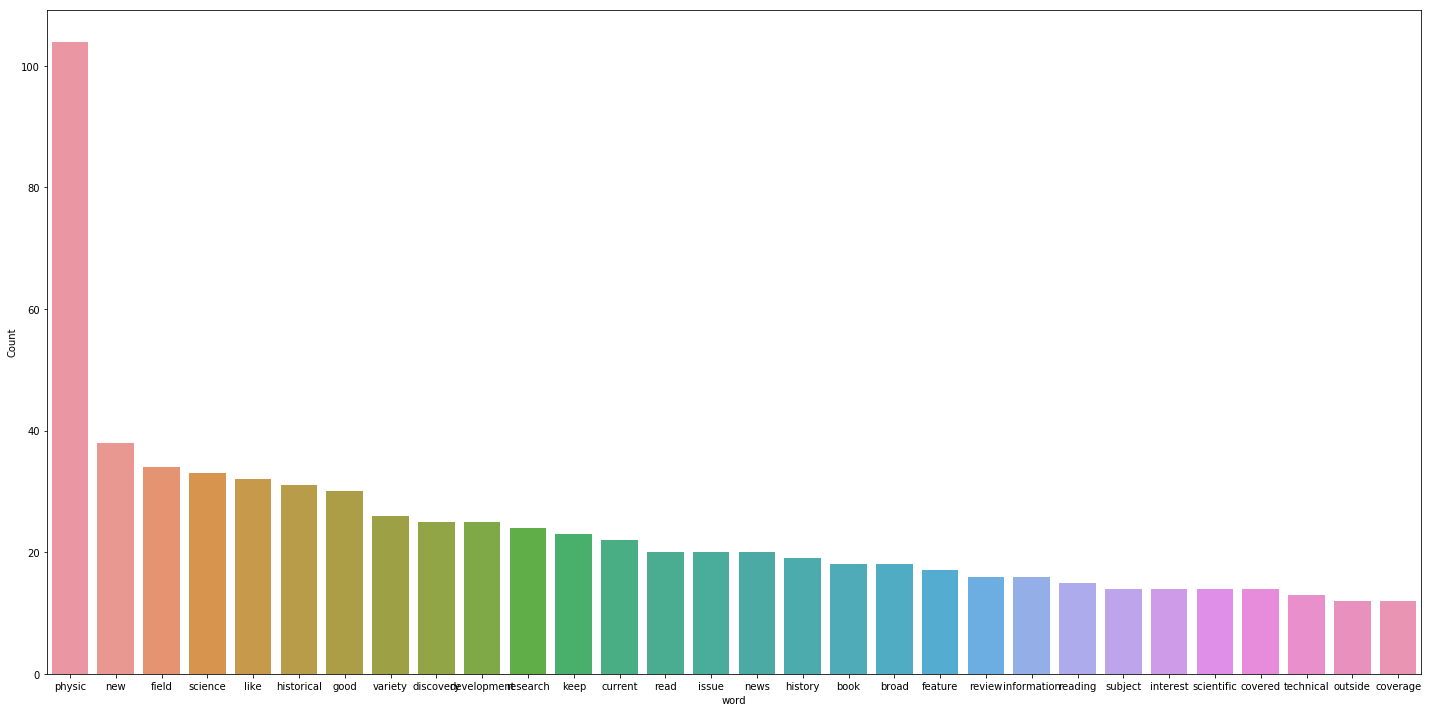

In [8]:
freq_words(data_clean['reviews_without_stopwords'])

## Building an LDA model


In [9]:
review = [word for word in data_clean['reviews_without_stopwords']]

In [10]:
tokenized_reviews = pd.Series(review).apply(lambda x: x.split())

In [11]:
dictionary = corpora.Dictionary(tokenized_reviews)

In [12]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]


In [13]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [14]:
lda_model.print_topics()

[(0,
  '0.026*"variety" + 0.023*"information" + 0.017*"research" + 0.015*"physic" + 0.012*"outside" + 0.012*"issue" + 0.010*"informative" + 0.010*"timely" + 0.010*"physicist" + 0.010*"read"'),
 (1,
  '0.036*"physic" + 0.031*"broad" + 0.024*"range" + 0.023*"covered" + 0.022*"discovery" + 0.014*"scientific" + 0.014*"historical" + 0.013*"search" + 0.012*"like" + 0.012*"breadth"'),
 (2,
  '0.070*"physic" + 0.029*"development" + 0.029*"new" + 0.018*"field" + 0.018*"coverage" + 0.017*"science" + 0.015*"current" + 0.015*"keep" + 0.013*"research" + 0.013*"technical"'),
 (3,
  '0.045*"science" + 0.029*"physic" + 0.023*"news" + 0.021*"recent" + 0.016*"field" + 0.015*"physicist" + 0.015*"variety" + 0.011*"research" + 0.010*"new" + 0.009*"quality"'),
 (4,
  '0.025*"good" + 0.020*"historical" + 0.020*"feature" + 0.017*"like" + 0.017*"new" + 0.016*"physic" + 0.016*"subject" + 0.014*"something" + 0.012*"letter" + 0.011*"interest"'),
 (5,
  '0.034*"book" + 0.031*"review" + 0.028*"physic" + 0.023*"hist

In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

/Users/reggieyang/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.056649  0.013094       1        1  20.048792
4     -0.108565  0.066951       2        1  17.043417
6      0.060035 -0.052931       3        1  13.939834
1     -0.028540 -0.154868       4        1  13.610956
0      0.027092  0.054421       5        1  13.532780
5     -0.121907  0.019568       6        1  11.690835
3      0.115235  0.053765       7        1  10.133388, topic_info=    Category       Freq           Term      Total  loglift  logprob
24   Default  25.000000        science  25.000000  30.0000  30.0000
156  Default  13.000000           book  13.000000  29.0000  29.0000
23   Default  12.000000         review  12.000000  28.0000  28.0000
185  Default  14.000000          broad  14.000000  27.0000  27.0000
21   Default  15.000000           news  15.000000  26.0000  26.0000
186  Default   8.000000          range   8.000000  25.0000  25.0000
168  Default  12.000000    information  12.000000  24.0000  24.0000
276  Default  11.000000        covered  11.000000  23.0000  23.0000
27   Default  20.000000        variety  20.000000  22.0000  22.0000
88   Default  19.000000    development  19.000000  21.0000  21.0000
92   Default  14.000000        history  14.000000  20.0000  20.0000
105  Default   7.000000         recent   7.000000  19.0000  19.0000
61   Default  10.000000       coverage  10.000000  18.0000  18.0000
65   Default   8.000000      physicist   8.000000  17.0000  17.0000
165  Default  13.000000        feature  13.000000  16.0000  16.0000
78   Default  23.000000           good  23.000000  15.0000  15.0000
32   Default  19.000000      discovery  19.000000  14.0000  14.0000
46   Default  79.000000         physic  79.000000  13.0000  13.0000
87   Default  17.000000        current  17.000000  12.0000  12.0000
297  Default   8.000000         search   8.000000  11.0000  11.0000
31   Default  18.000000       research  18.000000  10.0000  10.0000
30   Default  18.000000           keep  18.000000   9.0000   9.0000
187  Default  11.000000     scientific  11.000000   8.0000   8.0000
11   Default  29.000000            new  29.000000   7.0000   7.0000
104  Default   7.000000      something   7.000000   6.0000   6.0000
215  Default   8.000000         letter   8.000000   5.0000   5.0000
20   Default  24.000000     historical  24.000000   4.0000   4.0000
420  Default   5.000000          piece   5.000000   3.0000   3.0000
15   Default  11.000000        subject  11.000000   2.0000   2.0000
60   Default   9.000000        breadth   9.000000   1.0000   1.0000
..       ...        ...            ...        ...      ...      ...
419   Topic7   0.812323       engaging   1.457003   1.7051  -5.6769
145   Topic7   2.234481       material   4.404118   1.6108  -4.6650
24    Topic7  10.681416        science  25.277641   1.4279  -3.1005
22    Topic7   1.523420        product   2.938968   1.6322  -5.0480
461   Topic7   1.523404         result   2.939002   1.6322  -5.0481
38    Topic7   1.523302           easy   2.946864   1.6295  -5.0481
383   Topic7   2.032757           idea   4.295657   1.5411  -4.7596
65    Topic7   3.655639      physicist   8.828738   1.4076  -4.1727
21    Topic7   5.422558           news  15.163532   1.2610  -3.7784
138   Topic7   2.235333        quality   5.147527   1.4552  -4.6646
250   Topic7   2.234437     understand   5.175333   1.4494  -4.6650
44    Topic7   1.523368   occasionally   3.694623   1.4034  -5.0481
254   Topic7   1.523266           feel   3.694721   1.4033  -5.0481
210   Topic7   2.233992         update   6.654546   1.1978  -4.6652
27    Topic7   3.654133        variety  20.223713   0.5783  -4.1731
39    Topic7   1.523427         enough   4.453787   1.2165  -5.0480
322   Topic7   1.523458          daily   4.456746   1.2159  -5.0480
6     Topic7   3.883195          field  26.215017   0.3797  -4.1123
46    Topic7   6.970864         physic  79.372726  -0.1431  -3.5273
0  

In [16]:
corpus_transformed = lda_model[doc_term_matrix]
from operator import itemgetter
score_list = []
for topic in corpus_transformed:
        score_list.append(max(topic,key=itemgetter(1)))
data_clean['topic_score'] = score_list

In [17]:
data_clean

,like_review,text_lemmatized,reviews_without_stopwords,topic_score
0,learning new things outside my field and being inspired by cutting edge advances in theory or experiment love to read it cover to cover but had not caught up to the nov issue yet subject of this...,learning new thing outside my field and being inspired by cutting edge advance in theory or experiment love to read it cover to cover but had not caught up to the nov issue yet subject of this survey,learning new thing outside field inspired cutting edge advance theory experiment love read cover cover caught nov issue yet subject survey,"(4, 0.96092457)"
1,science articles product reviews science news and historical articles,science article product review science news and historical article,science product review science news historical,"(3, 0.5373201)"
2,the variety of hot topics and the historical tidbits,the variety of hot topic and the historical tidbit,variety hot historical tidbit,"(2, 0.8275461)"
3,keeps me up to date and exposes me to new research,keep me up to date and expose me to new research,keep date expose new research,"(2, 0.85679466)"
4,i like the discovery news and the articles on environmental issues,i like the discovery news and the article on environmental issue,like discovery news environmental issue,"(5, 0.6453804)"
5,the historical articles,the historical article,historical,"(4, 0.57035226)"
6,it brings me easy to read news about physics and related fields with enough technical detail to interest me as a professional the stories are often well enough explained for a layman as well so m...,it brings me easy to read news about physic and related field with enough technical detail to interest me a a professional the story are often well enough explained for a layman a well so much so ...,brings easy read news physic related field enough technical detail interest professional story often enough explained layman use undergraduate class occasionally send friend,"(3, 0.9641939)"
7,variety of subjects,variety of subject,variety subject,"(4, 0.7134617)"
8,i like most when others use it to teach folks like me their subject matter i want to learn some physics,i like most when others use it to teach folk like me their subject matter i want to learn some physic,like others use teach folk like subject matter want learn physic,"(4, 0.9284202)"
9,breadth of coverage,breadth of coverage,breadth coverage,"(2, 0.7139402)"


In [18]:
#count each topic
def extract_topic(df):
        return df[0]
data_clean['topic'] = data_clean['topic_score'].apply(extract_topic)

#add column with topic content
def add_content(df):
    if int(df)==7:
        return 'Others'
    else:
        return lda_model.print_topics()[int(df)]
data_clean['topic_content'] = data_clean['topic'].apply(add_content)

In [19]:
topic_dic = {0:'broad topic',1:'history new discovery',2:'subject, detail, level',3:'variety',
             4:'discovery feature',5:'topic coverage',6:'new science development',7:'Others'}
data_clean['topic_content2'] = data_clean['topic'].map(topic_dic)

In [20]:
data_clean = data_clean[['like_review','topic_score','topic','topic_content','topic_content2']]
data_clean

,like_review,topic_score,topic,topic_content,topic_content2
0,learning new things outside my field and being inspired by cutting edge advances in theory or experiment love to read it cover to cover but had not caught up to the nov issue yet subject of this...,"(4, 0.96092457)",4,"(4, 0.025*""good"" + 0.020*""historical"" + 0.020*""feature"" + 0.017*""like"" + 0.017*""new"" + 0.016*""physic"" + 0.016*""subject"" + 0.014*""something"" + 0.012*""letter"" + 0.011*""interest"")",discovery feature
1,science articles product reviews science news and historical articles,"(3, 0.5373201)",3,"(3, 0.045*""science"" + 0.029*""physic"" + 0.023*""news"" + 0.021*""recent"" + 0.016*""field"" + 0.015*""physicist"" + 0.015*""variety"" + 0.011*""research"" + 0.010*""new"" + 0.009*""quality"")",variety
2,the variety of hot topics and the historical tidbits,"(2, 0.8275461)",2,"(2, 0.070*""physic"" + 0.029*""development"" + 0.029*""new"" + 0.018*""field"" + 0.018*""coverage"" + 0.017*""science"" + 0.015*""current"" + 0.015*""keep"" + 0.013*""research"" + 0.013*""technical"")","subject, detail, level"
3,keeps me up to date and exposes me to new research,"(2, 0.85679466)",2,"(2, 0.070*""physic"" + 0.029*""development"" + 0.029*""new"" + 0.018*""field"" + 0.018*""coverage"" + 0.017*""science"" + 0.015*""current"" + 0.015*""keep"" + 0.013*""research"" + 0.013*""technical"")","subject, detail, level"
4,i like the discovery news and the articles on environmental issues,"(5, 0.6453804)",5,"(5, 0.034*""book"" + 0.031*""review"" + 0.028*""physic"" + 0.023*""history"" + 0.022*""news"" + 0.015*""field"" + 0.014*""historical"" + 0.013*""new"" + 0.013*""job"" + 0.013*""like"")",topic coverage
5,the historical articles,"(4, 0.57035226)",4,"(4, 0.025*""good"" + 0.020*""historical"" + 0.020*""feature"" + 0.017*""like"" + 0.017*""new"" + 0.016*""physic"" + 0.016*""subject"" + 0.014*""something"" + 0.012*""letter"" + 0.011*""interest"")",discovery feature
6,it brings me easy to read news about physics and related fields with enough technical detail to interest me as a professional the stories are often well enough explained for a layman as well so m...,"(3, 0.9641939)",3,"(3, 0.045*""science"" + 0.029*""physic"" + 0.023*""news"" + 0.021*""recent"" + 0.016*""field"" + 0.015*""physicist"" + 0.015*""variety"" + 0.011*""research"" + 0.010*""new"" + 0.009*""quality"")",variety
7,variety of subjects,"(4, 0.7134617)",4,"(4, 0.025*""good"" + 0.020*""historical"" + 0.020*""feature"" + 0.017*""like"" + 0.017*""new"" + 0.016*""physic"" + 0.016*""subject"" + 0.014*""something"" + 0.012*""letter"" + 0.011*""interest"")",discovery feature
8,i like most when others use it to teach folks like me their subject matter i want to learn some physics,"(4, 0.9284202)",4,"(4, 0.025*""good"" + 0.020*""historical"" + 0.020*""feature"" + 0.017*""like"" + 0.017*""new"" + 0.016*""physic"" + 0.016*""subject"" + 0.014*""something"" + 0.012*""letter"" + 0.011*""interest"")",discovery feature
9,breadth of coverage,"(2, 0.7139402)",2,"(2, 0.070*""physic"" + 0.029*""development"" + 0.029*""new"" + 0.018*""field"" + 0.018*""coverage"" + 0.017*""science"" + 0.015*""current"" + 0.015*""keep"" + 0.013*""research"" + 0.013*""technical"")","subject, detail, level"


In [21]:
#data_clean.to_excel('/Users/reggieyang/Desktop/Python/Summer Projects/NLP/final report/like_result.xlsx')

In [23]:
dict(data_clean['topic'].value_counts())

{2: 83, 4: 64, 5: 59, 0: 59, 1: 54, 6: 40, 3: 33}